In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp,udf,desc
from pyspark.sql import Window

In [5]:
spark = SparkSession.builder.appName('weather prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

In [113]:
input = '/home/kchakola/sfuhome/EDS_6.csv.gz'
# Defining the schema for tmax datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()
#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

In [114]:
temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,Z from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'")

temp.show()

+--------------------+---------+
|           timestamp|        Z|
+--------------------+---------+
|2018-07-09 12:00:...|-1.117188|
|2018-07-09 12:00:...|-1.117188|
|2018-07-09 12:00:...|-1.113281|
|2018-07-09 12:00:...|-1.121094|
|2018-07-09 12:00:...|-1.109375|
|2018-07-09 12:00:...|-1.117188|
|2018-07-09 12:00:...|-1.113281|
|2018-07-09 12:00:...|-1.117188|
|2018-07-09 12:00:...|-1.117188|
|2018-07-09 12:00:...|-1.117188|
|2018-07-09 12:00:...|-1.117188|
|2018-07-09 12:00:...|-1.113281|
|2018-07-09 12:00:...|-1.121094|
|2018-07-09 12:00:...|-1.121094|
|2018-07-09 12:00:...|-1.117188|
|2018-07-09 12:00:...|-1.113281|
|2018-07-09 12:00:...|-1.117188|
|2018-07-09 12:00:...|-1.121094|
|2018-07-09 12:00:...|-1.121094|
|2018-07-09 12:00:...|-1.121094|
+--------------------+---------+
only showing top 20 rows



In [115]:
#since elevator 6 sensor is fixed in negative axis
temp = temp.withColumn('Z', temp['Z']*(-1))

temp.show()

+--------------------+--------+
|           timestamp|       Z|
+--------------------+--------+
|2018-07-09 12:00:...|1.117188|
|2018-07-09 12:00:...|1.117188|
|2018-07-09 12:00:...|1.113281|
|2018-07-09 12:00:...|1.121094|
|2018-07-09 12:00:...|1.109375|
|2018-07-09 12:00:...|1.117188|
|2018-07-09 12:00:...|1.113281|
|2018-07-09 12:00:...|1.117188|
|2018-07-09 12:00:...|1.117188|
|2018-07-09 12:00:...|1.117188|
|2018-07-09 12:00:...|1.117188|
|2018-07-09 12:00:...|1.113281|
|2018-07-09 12:00:...|1.121094|
|2018-07-09 12:00:...|1.121094|
|2018-07-09 12:00:...|1.117188|
|2018-07-09 12:00:...|1.113281|
|2018-07-09 12:00:...|1.117188|
|2018-07-09 12:00:...|1.121094|
|2018-07-09 12:00:...|1.121094|
|2018-07-09 12:00:...|1.121094|
+--------------------+--------+
only showing top 20 rows



### Plots of Raw data

In [123]:
temp.createOrReplaceTempView("rawData")
temp_df = spark.sql("select timestamp,Z from rawData where timestamp between '2018-07-09 12:00:00' and '2018-07-09 12:00:10'").cache()

In [124]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [125]:
%time raw_pandas = temp_df.select("*").toPandas()

CPU times: user 18.6 ms, sys: 419 µs, total: 19 ms
Wall time: 3min


(array([  0.,  50., 100., 150., 200., 250.]),
 <a list of 6 Text xticklabel objects>)

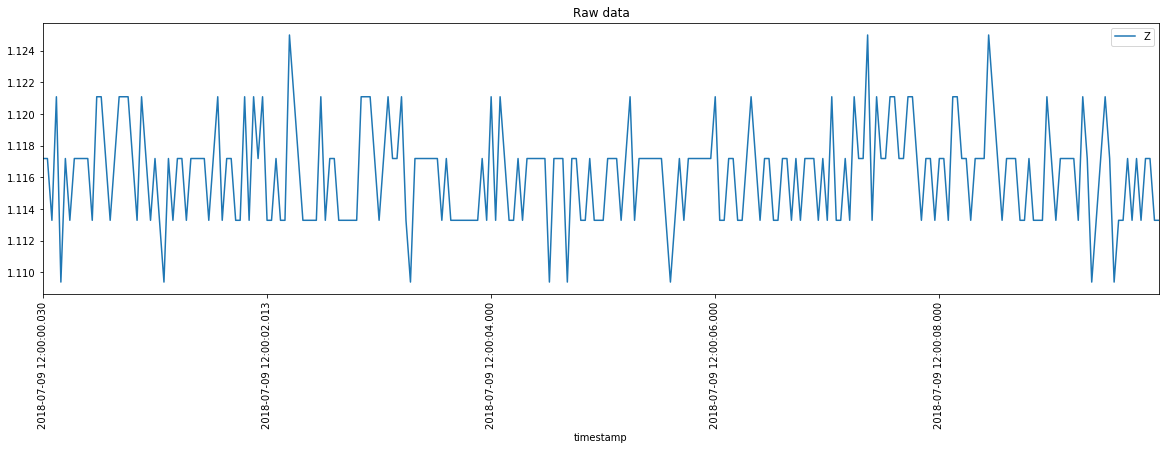

In [126]:
raw_pandas.plot(x ='timestamp', y='Z', kind = 'line', figsize=(20,5))
plt.title("Raw data")
plt.xticks(rotation=90)

In [127]:
# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["Z"],
    outputCol="Zvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()
scaledData.show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-09 12:00:...|1.117188|-0.092362|
|2018-07-09 12:00:...|1.117188|-0.092362|
|2018-07-09 12:00:...|1.113281|-0.539691|
|2018-07-09 12:00:...|1.121094| 0.354853|
|2018-07-09 12:00:...|1.109375|-0.986906|
|2018-07-09 12:00:...|1.117188|-0.092362|
|2018-07-09 12:00:...|1.113281|-0.539691|
|2018-07-09 12:00:...|1.117188|-0.092362|
|2018-07-09 12:00:...|1.117188|-0.092362|
|2018-07-09 12:00:...|1.117188|-0.092362|
|2018-07-09 12:00:...|1.117188|-0.092362|
|2018-07-09 12:00:...|1.113281|-0.539691|
|2018-07-09 12:00:...|1.121094| 0.354853|
|2018-07-09 12:00:...|1.121094| 0.354853|
|2018-07-09 12:00:...|1.117188|-0.092362|
|2018-07-09 12:00:...|1.113281|-0.539691|
|2018-07-09 12:00:...|1.117188|-0.092362|
|2018-07-09 12:00:...|1.121094| 0.354853|
|2018-07-09 12:00:...|1.121094| 0.354853|
|2018-07-09 12:00:...|1.121094| 0.354853|
+--------------------+--------+---

In [10]:
scaledData.sort(desc("Zscale")).show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-08-02 14:12:...|1.605469|55.813049|
|2018-08-02 14:12:...|1.546875|49.104368|
|2018-07-18 10:01:...|     1.5|43.737446|
|2018-07-18 10:01:...|1.480469|41.501257|
|2018-07-11 11:34:...|1.460938|39.265068|
|2018-07-18 10:01:...|1.460938|39.265068|
|2018-07-18 10:01:...|1.445313|37.476094|
|2018-07-13 07:52:...|1.410156|33.450816|
|2018-07-18 10:01:...|1.394531|31.661842|
|2018-07-18 10:01:...|1.371094|28.978438|
|2018-07-18 10:01:...|1.371094|28.978438|
|2018-07-18 10:01:...|1.367188|28.531223|
|2018-07-17 06:42:...|1.363281|28.083894|
|2018-08-02 14:17:...|1.363281|28.083894|
|2018-07-16 08:26:...|1.359375|27.636679|
|2018-07-11 11:34:...|1.351563|26.742249|
|2018-07-30 07:51:...|1.351563|26.742249|
|2018-07-18 10:01:...|1.351563|26.742249|
|2018-08-02 14:12:...|1.351563|26.742249|
|2018-08-02 14:17:...|1.351563|26.742249|
+--------------------+--------+---

In [11]:
scaledData.sort("Zscale").show()

+--------------------+---------+-----------+
|           timestamp|        Z|     Zscale|
+--------------------+---------+-----------+
|2018-07-31 08:12:...|-0.203125|-151.260727|
|2018-07-27 07:41:...| 0.777344| -39.002576|
|2018-07-18 12:43:...|   0.8125| -34.977413|
|2018-07-18 12:43:...|   0.8125| -34.977413|
|2018-07-18 12:43:...| 0.816406| -34.530198|
|2018-07-18 12:32:...| 0.820313| -34.082869|
|2018-07-18 12:47:...| 0.835938| -32.293895|
|2018-07-18 12:29:...| 0.847656|  -30.95225|
|2018-07-18 12:32:...| 0.851563| -30.504921|
|2018-07-18 12:43:...| 0.851563| -30.504921|
|2018-07-18 12:43:...| 0.851563| -30.504921|
|2018-07-18 12:43:...| 0.855469| -30.057706|
|2018-07-18 12:43:...| 0.863281| -29.163276|
|2018-07-18 12:43:...| 0.867188| -28.715947|
|2018-07-18 12:47:...| 0.871094| -28.268732|
|2018-07-18 10:01:...|    0.875| -27.821517|
|2018-07-16 13:08:...| 0.878906| -27.374302|
|2018-07-18 12:29:...| 0.882813| -26.926973|
|2018-07-18 12:43:...| 0.886719| -26.479758|
|2018-08-0

In [103]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select timestamp,Zscale from scaledData where timestamp between '2018-07-18 12:43:00' and '2018-07-18 12:44:00'").cache()

In [104]:
temp_df = temp_df.withColumn("timestamp1", to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()
temp_df.show()

+--------------------+----------+-------------------+
|           timestamp|    Zscale|         timestamp1|
+--------------------+----------+-------------------+
|2018-07-18 12:43:...|  2.591042|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  1.249283|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  1.249283|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  2.143827|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  1.696612|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  0.802068|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  1.249283|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  1.696612|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  1.696612|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  1.696612|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  1.696612|2018-07-18 12:43:00|
|2018-07-18 12:43:...|  1.696612|2018-07-18 12:43:00|
|2018-07-18 12:43:...|-14.404154|2018-07-18 12:43:00|
|2018-07-18 12:43:...|-26.479758|2018-07-18 12:43:00|
|2018-07-18 12:43:...|-34.977413|2018-07-18 12:43:00|
|2018-07-18 12:43:...|-30.05

In [105]:
movAvg = temp_df.withColumn("movingAverage", avg(temp_df["Zscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-1,1))).cache()
movAvg.show()

+--------------------+---------+-------------------+--------------------+
|           timestamp|   Zscale|         timestamp1|       movingAverage|
+--------------------+---------+-------------------+--------------------+
|2018-07-18 12:43:...|-0.092362|2018-07-18 12:43:35|          -0.3160265|
|2018-07-18 12:43:...|-0.539691|2018-07-18 12:43:35| -0.3905813333333333|
|2018-07-18 12:43:...|-0.539691|2018-07-18 12:43:35|           -0.539691|
|2018-07-18 12:43:...|-0.539691|2018-07-18 12:43:35| -0.3905813333333334|
|2018-07-18 12:43:...|-0.092362|2018-07-18 12:43:35|-0.24147166666666667|
|2018-07-18 12:43:...|-0.092362|2018-07-18 12:43:35|           -0.092362|
|2018-07-18 12:43:...|-0.092362|2018-07-18 12:43:35|           -0.092362|
|2018-07-18 12:43:...|-0.092362|2018-07-18 12:43:35|-0.24147166666666667|
|2018-07-18 12:43:...|-0.539691|2018-07-18 12:43:35| -0.3905813333333333|
|2018-07-18 12:43:...|-0.539691|2018-07-18 12:43:35|           -0.539691|
|2018-07-18 12:43:...|-0.539691|2018-0

In [106]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [107]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 145 ms


### Plots of Normal data

In [223]:
roundData = scaledData.withColumn("Zround", functions.round(scaledData['Zscale']).cast('integer'))

roundData.show()

+--------------------+--------+---------+------+
|           timestamp|       Z|   Zscale|Zround|
+--------------------+--------+---------+------+
|2018-07-09 12:00:...|1.117188|-0.092362|     0|
|2018-07-09 12:00:...|1.117188|-0.092362|     0|
|2018-07-09 12:00:...|1.113281|-0.539691|    -1|
|2018-07-09 12:00:...|1.121094| 0.354853|     0|
|2018-07-09 12:00:...|1.109375|-0.986906|    -1|
|2018-07-09 12:00:...|1.117188|-0.092362|     0|
|2018-07-09 12:00:...|1.113281|-0.539691|    -1|
|2018-07-09 12:00:...|1.117188|-0.092362|     0|
|2018-07-09 12:00:...|1.117188|-0.092362|     0|
|2018-07-09 12:00:...|1.117188|-0.092362|     0|
|2018-07-09 12:00:...|1.117188|-0.092362|     0|
|2018-07-09 12:00:...|1.113281|-0.539691|    -1|
|2018-07-09 12:00:...|1.121094| 0.354853|     0|
|2018-07-09 12:00:...|1.121094| 0.354853|     0|
|2018-07-09 12:00:...|1.117188|-0.092362|     0|
|2018-07-09 12:00:...|1.113281|-0.539691|    -1|
|2018-07-09 12:00:...|1.117188|-0.092362|     0|
|2018-07-09 12:00:..

In [224]:
df_round = roundData.groupby('Zround').agg(functions.count('Zround').alias('count'))
df_round.show()

+------+--------+
|Zround|   count|
+------+--------+
|   -35|       3|
|   -13|   41934|
|   -20|      12|
|    -1|12286550|
|   -17|      22|
|   -21|      14|
|    28|       3|
|    27|       5|
|    26|       3|
|   -10|   61395|
|    44|       1|
|   -11|   18526|
|    12|   13064|
|   -27|       2|
|    22|       8|
|   -15|    4804|
|     1| 3378811|
|   -39|       1|
|    13|   36923|
|     6|    9853|
+------+--------+
only showing top 20 rows



In [225]:
df_round.toPandas().to_csv("lift6_Zround.csv", header=True)

In [170]:
roundData.createOrReplaceTempView("roundDatap")
roundp_df = spark.sql("select timestamp, Z, Zscale from roundDatap where Zscale > -14.5 and Zscale < -13.5").cache()

roundp_df.show(50)

+--------------------+--------+----------+
|           timestamp|       Z|    Zscale|
+--------------------+--------+----------+
|2018-07-09 12:06:...|     1.0|-13.509724|
|2018-07-09 12:06:...|0.992188|-14.404154|
|2018-07-09 12:06:...|     1.0|-13.509724|
|2018-07-09 12:06:...|     1.0|-13.509724|
|2018-07-09 12:06:...|     1.0|-13.509724|
|2018-07-09 12:06:...|0.996094|-13.956939|
|2018-07-09 12:06:...|     1.0|-13.509724|
|2018-07-09 12:06:...|     1.0|-13.509724|
|2018-07-09 12:07:...|     1.0|-13.509724|
|2018-07-09 12:07:...|0.996094|-13.956939|
|2018-07-09 12:07:...|0.992188|-14.404154|
|2018-07-09 12:07:...|0.996094|-13.956939|
|2018-07-09 12:07:...|     1.0|-13.509724|
|2018-07-09 12:07:...|     1.0|-13.509724|
|2018-07-09 12:07:...|     1.0|-13.509724|
|2018-07-09 12:07:...|     1.0|-13.509724|
|2018-07-09 12:07:...|     1.0|-13.509724|
|2018-07-09 12:07:...|     1.0|-13.509724|
|2018-07-09 12:07:...|     1.0|-13.509724|
|2018-07-09 12:09:...|0.992188|-14.404154|
|2018-07-09

In [217]:
scaledData.createOrReplaceTempView("roundDatap1")
roundp_df1 = spark.sql("select timestamp,Zscale from roundDatap1 where timestamp between '2018-07-09 12:09:20' and '2018-07-09 12:09:50'").cache()

roundp_df1.show()

+--------------------+---------+
|           timestamp|   Zscale|
+--------------------+---------+
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...|-0.539691|
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...|-0.986906|
|2018-07-09 12:09:...| 0.354853|
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...| 0.354853|
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...|-0.539691|
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...| 0.802068|
|2018-07-09 12:09:...| 0.354853|
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...|-0.539691|
|2018-07-09 12:09:...|-0.539691|
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...|-0.092362|
|2018-07-09 12:09:...|-0.092362|
+--------------------+---------+
only showing top 20 rows



In [218]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [219]:
%time roundp_df1_pandas = roundp_df1.select("*").toPandas()

CPU times: user 4.55 ms, sys: 3.8 ms, total: 8.35 ms
Wall time: 27.2 ms


### Plots

(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text xticklabel objects>)

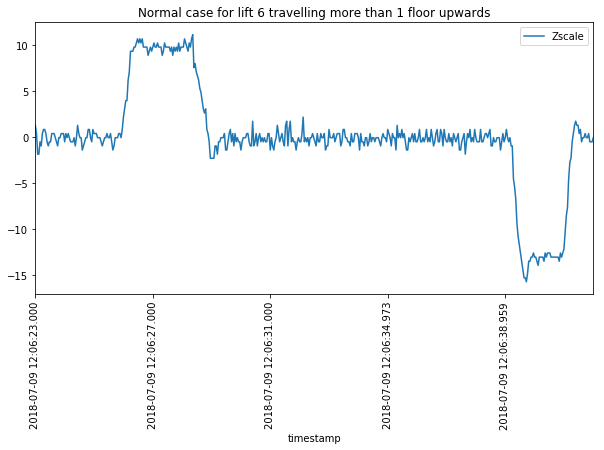

In [165]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 6 travelling more than 1 floor upwards")
plt.xticks(rotation=90)

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 <a list of 8 Text xticklabel objects>)

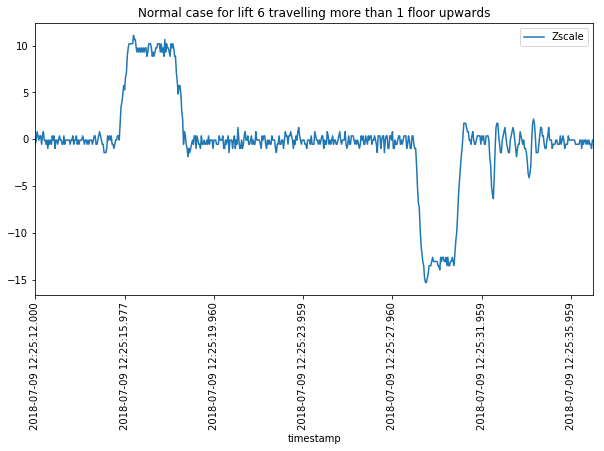

In [182]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 6 travelling more than 1 floor upwards")
plt.xticks(rotation=90)

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 <a list of 6 Text xticklabel objects>)

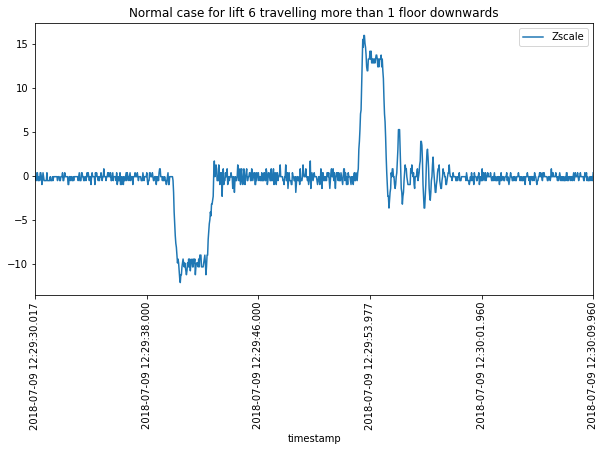

In [195]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 6 travelling more than 1 floor downwards")
plt.xticks(rotation=90)

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 <a list of 9 Text xticklabel objects>)

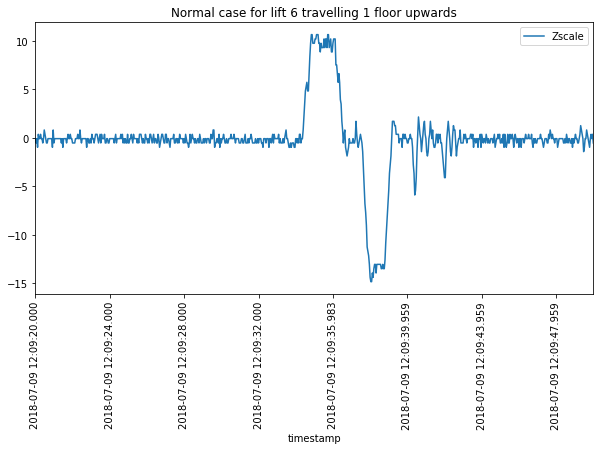

In [221]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 6 travelling 1 floor upwards")
plt.xticks(rotation=90)

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800.]),
 <a list of 9 Text xticklabel objects>)

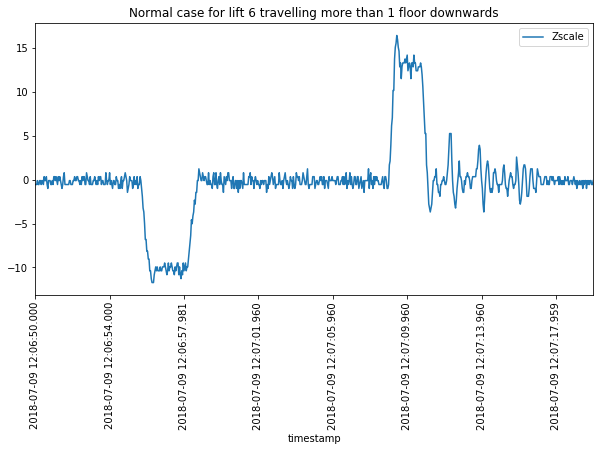

In [208]:
roundp_df1_pandas.plot(x ='timestamp', y='Zscale', kind = 'line', figsize=(10,5))
plt.title("Normal case for lift 6 travelling more than 1 floor downwards")
plt.xticks(rotation=90)

### Plots of Anomalies detected for Lift 6. 10 different anomalies are plotted here

### Plots of Anomaly 1

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

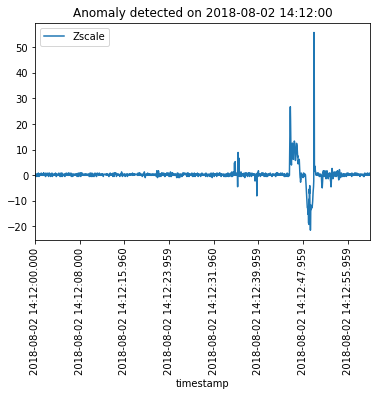

In [17]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Normal case for lift travelling more than 1 floor")
plt.xticks(rotation=90)

In [18]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 137 ms, sys: 7.29 ms, total: 144 ms
Wall time: 800 ms


(array([736908.59166667, 736908.59178241, 736908.59189815, 736908.59201389,
        736908.59212963, 736908.59224537]),
 <a list of 6 Text xticklabel objects>)

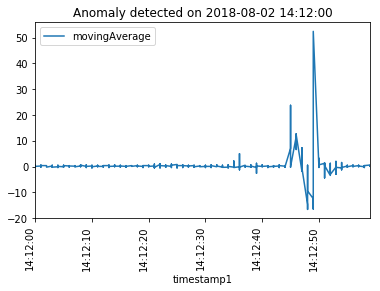

In [19]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-08-02 14:12:00")
plt.xticks(rotation=90)

### Plots of Anomaly 2

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

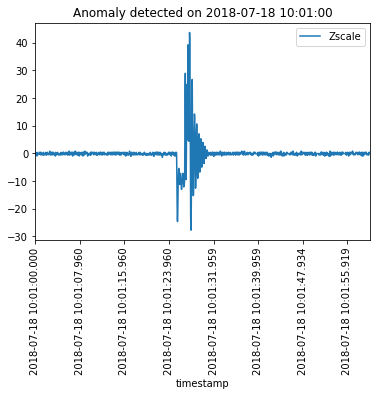

In [25]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 10:01:00")
plt.xticks(rotation=90)

In [26]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 141 ms, sys: 6.69 ms, total: 148 ms
Wall time: 619 ms


(array([736893.41736111, 736893.41747685, 736893.41759259, 736893.41770833,
        736893.41782407, 736893.41793981]),
 <a list of 6 Text xticklabel objects>)

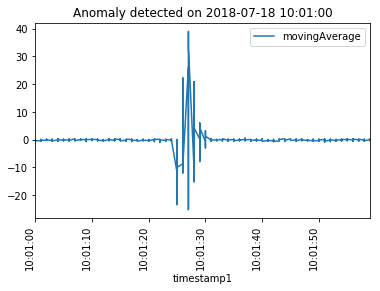

In [28]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 10:01:00")
plt.xticks(rotation=90)

### Plots of Anomaly 3

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

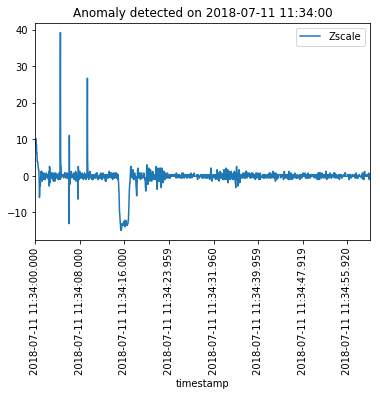

In [34]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-11 11:34:00")
plt.xticks(rotation=90)

In [35]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 116 ms, sys: 15.9 ms, total: 132 ms
Wall time: 508 ms


(array([736886.48194444, 736886.48206019, 736886.48217593, 736886.48229167,
        736886.48240741, 736886.48252315]),
 <a list of 6 Text xticklabel objects>)

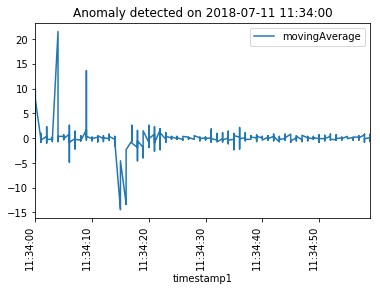

In [36]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-11 11:34:00")
plt.xticks(rotation=90)

### Plots of Anomaly 4

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

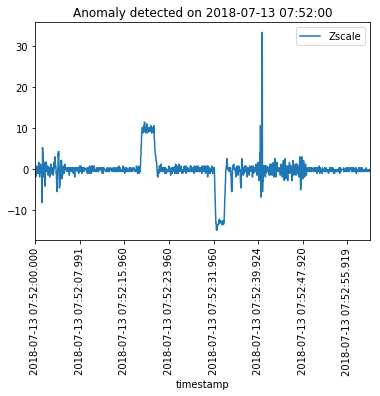

In [42]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 07:52:00")
plt.xticks(rotation=90)

In [43]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 128 ms, sys: 7.57 ms, total: 136 ms
Wall time: 503 ms


(array([736888.32777778, 736888.32789352, 736888.32800926, 736888.328125  ,
        736888.32824074, 736888.32835648]),
 <a list of 6 Text xticklabel objects>)

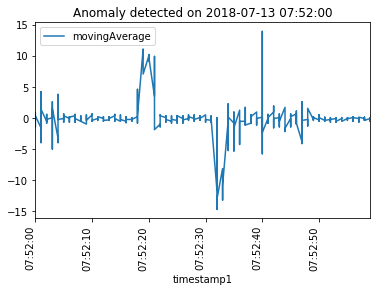

In [45]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-13 07:52:00")
plt.xticks(rotation=90)

### Plots of Anomaly 5

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

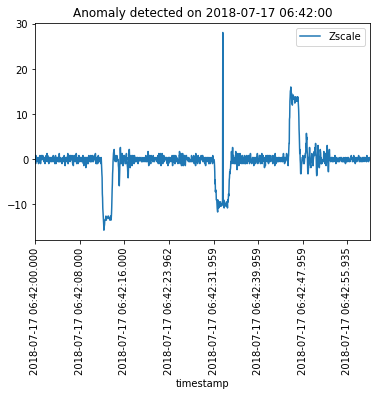

In [51]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-17 06:42:00")
plt.xticks(rotation=90)

In [52]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 128 ms, sys: 4.47 ms, total: 133 ms
Wall time: 457 ms


(array([736892.27916667, 736892.27928241, 736892.27939815, 736892.27951389,
        736892.27962963, 736892.27974537]),
 <a list of 6 Text xticklabel objects>)

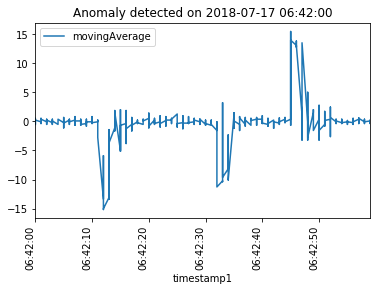

In [54]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-17 06:42:00")
plt.xticks(rotation=90)

### Plots of Anomaly 6

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

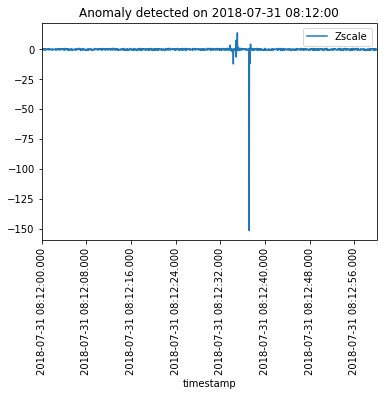

In [60]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 08:12:00")
plt.xticks(rotation=90)

In [61]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 130 ms, sys: 8.12 ms, total: 138 ms
Wall time: 425 ms


(array([736906.34166667, 736906.34178241, 736906.34189815, 736906.34201389,
        736906.34212963, 736906.34224537]),
 <a list of 6 Text xticklabel objects>)

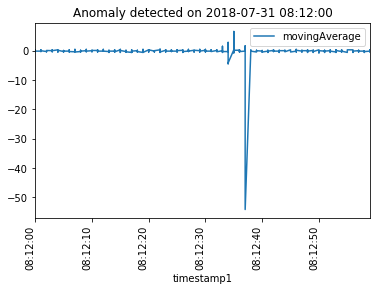

In [62]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-31 08:12:00")
plt.xticks(rotation=90)

### Plots of Anomaly 7

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

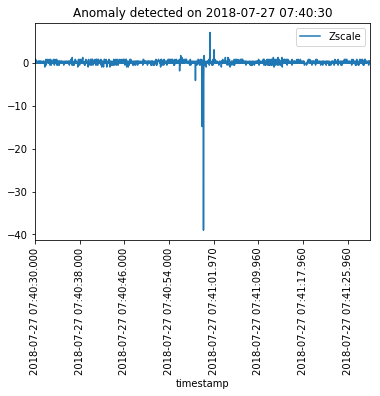

In [77]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 07:40:30")
plt.xticks(rotation=90)

In [78]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 124 ms, sys: 8 ms, total: 132 ms
Wall time: 426 ms


(array([736902.31979167, 736902.31990741, 736902.32002315, 736902.32013889,
        736902.32025463, 736902.32037037]),
 <a list of 6 Text xticklabel objects>)

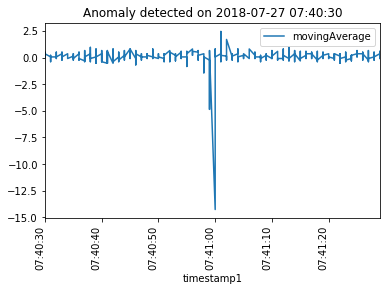

In [79]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 07:40:30")
plt.xticks(rotation=90)

### Plots of Anomaly 8

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

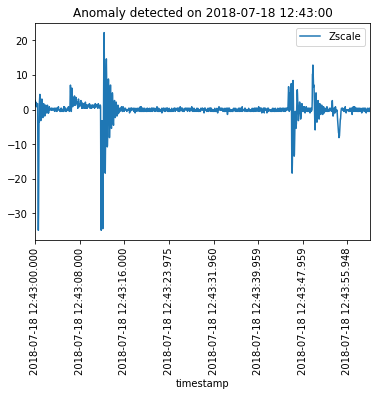

In [85]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 12:43:00")
plt.xticks(rotation=90)

In [86]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 126 ms, sys: 11.4 ms, total: 138 ms
Wall time: 408 ms


(array([736893.52986111, 736893.52997685, 736893.53009259, 736893.53020833,
        736893.53032407, 736893.53043981]),
 <a list of 6 Text xticklabel objects>)

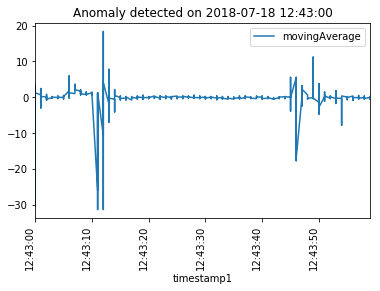

In [88]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 12:43:00")
plt.xticks(rotation=90)

### Plots of Anomaly 9

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

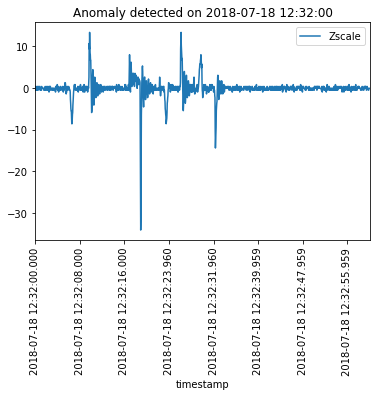

In [94]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 12:32:00")
plt.xticks(rotation=90)

In [95]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 128 ms, sys: 3.33 ms, total: 131 ms
Wall time: 374 ms


(array([736893.52222222, 736893.52233796, 736893.5224537 , 736893.52256944,
        736893.52268519, 736893.52280093]),
 <a list of 6 Text xticklabel objects>)

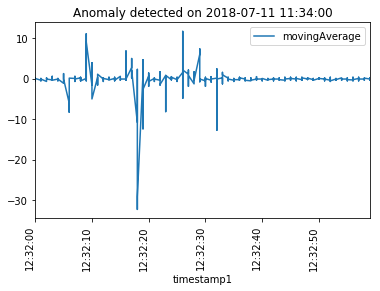

In [96]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-11 11:34:00")
plt.xticks(rotation=90)

### Plots of Anomaly 10

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 <a list of 9 Text xticklabel objects>)

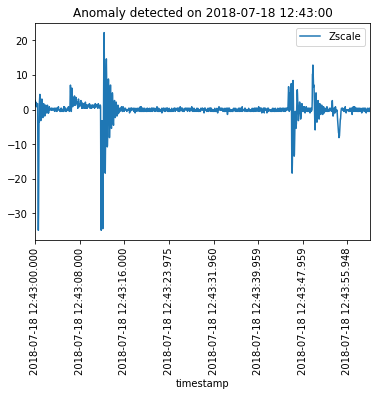

In [108]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 12:43:00")
plt.xticks(rotation=90)

In [109]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 136 ms, sys: 7.57 ms, total: 143 ms
Wall time: 257 ms


(array([736893.52986111, 736893.52997685, 736893.53009259, 736893.53020833,
        736893.53032407, 736893.53043981]),
 <a list of 6 Text xticklabel objects>)

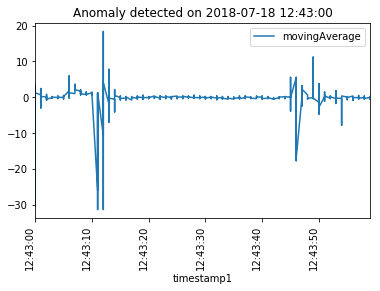

In [110]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-18 12:43:00")
plt.xticks(rotation=90)